In [1]:
#!pip install openpyxl
#https://clio-infra.eu/Indicators/GenderEqualityofNumeracy.html

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pd.options.mode.chained_assignment = None

In [2]:
df_var = pd.read_excel('other_data/GenderEqualityofNumeracy_Compact.xlsx', sheet_name='Data Long Format')
var = 'Gender_equality_num'

df_var = df_var.rename(columns={'value':var, 'country.name':'name'})
df_var = df_var.sort_values(var, ascending=False)


df_var = df_var.drop('name', axis=1)
df_ccode_iso = pd.read_csv('other_data/ccode_iso3.csv')
df_ccode_iso = df_ccode_iso[['name', 'country-code', 'alpha-3']]
df_ccode_iso.columns = ['name', 'ccode', 'iso_a3'].copy()

df_var = pd.merge(df_var, df_ccode_iso, on = 'ccode')

# load regions and equivalent country_name
df_regions_culture = pd.read_csv('other_data/ENS - Cultural Index - Countries Databases - consolidate_table.csv')
df_regions_culture = df_regions_culture[['region', 'iso_a3']].drop_duplicates()

df_var = pd.merge(df_var, df_regions_culture, on = 'iso_a3')
df_var = df_var.rename(columns={'name':'country_name'})
df_var['Gender_equality_num']=df_var['Gender_equality_num'] + abs(min(df_var['Gender_equality_num']))

min(df_var['Gender_equality_num'])


0.0

### Population (Maddison + Interpolation for every year)

In [3]:
df_population_interpolated = pd.read_csv('other_data/population_interpolated.csv', index_col=[0])
df_iso = pd.read_csv('other_data/iso.csv', index_col = [0])
df_population_interpolated = pd.merge(df_population_interpolated, df_iso, on = 'country_name')
df_population_interpolated

,country_name,year,pop,iso_a3
0,Albania,1,200.0,ALB
1,Albania,2,200.0,ALB
2,Albania,3,200.0,ALB
3,Albania,4,200.0,ALB
4,Albania,5,200.0,ALB
...,...,...,...,...
79336,Viet Nam,1896,10528.0,VNM
79337,Viet Nam,1897,10528.0,VNM
79338,Viet Nam,1898,10528.0,VNM
79339,Viet Nam,1899,10528.0,VNM


In [4]:
var_weighted = f'{var}_weighted'

df_var_pop = pd.merge(df_var, df_population_interpolated, on = ['year','iso_a3'])

df_var_w = df_var_pop.groupby(['region', 'year']).apply(lambda x: (x[var] * x['pop']).sum() / x['pop'].sum())
df_var_w = df_var_w.reset_index()
df_var_w = df_var_w.rename(columns={0: var_weighted})
df_var_w = df_var_w[df_var_w['year']<=1880]

df_var_w['decade'] = df_var_w['year'].apply(lambda x: round(x / 10) * 10)
df_var_w = df_var_w.groupby(['region', 'decade'])[var_weighted].mean().reset_index()
df_var_w.to_csv('other_data/f{var}_weighted_pop_decade.csv')

In [5]:
df_var_w

,region,decade,Gender_equality_num_weighted
0,Africa,1860,110.384200
1,Africa,1870,110.769300
2,Africa,1880,116.272048
3,Arabic world,1830,118.182570
4,Arabic world,1840,116.194570
...,...,...,...
298,mediterranean World,1840,115.108270
299,mediterranean World,1850,118.698904
300,mediterranean World,1860,112.978735
301,mediterranean World,1870,116.505556


### Visualize

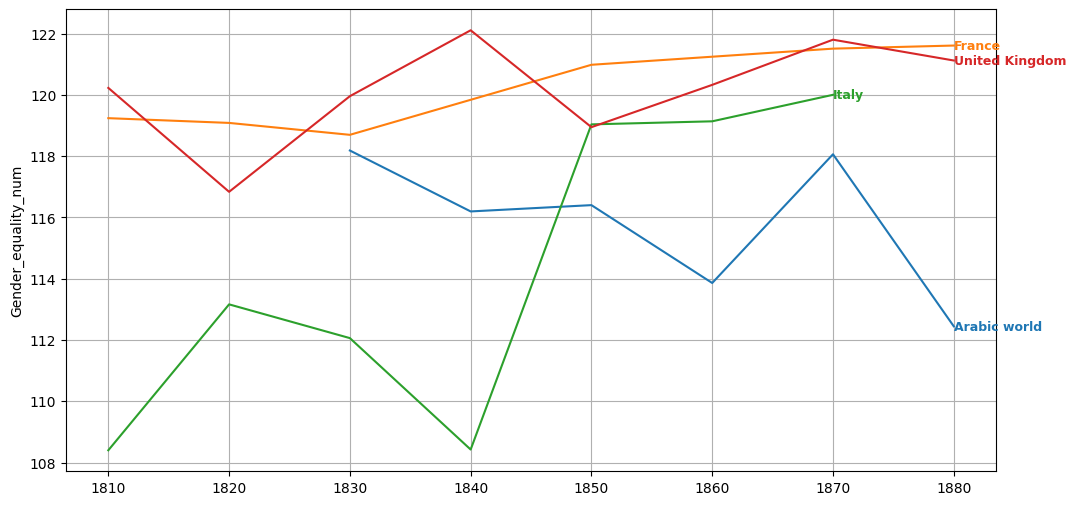

In [6]:
import matplotlib.pyplot as plt

df_fig = df_var_w[df_var_w['region'].isin(['France', 'Italy', 'Chinese world', 'United Kingdom', 'Arabic world'])]

# Re-plotting with country labels near each line
plt.figure(figsize=(12, 6))

for region in df_fig['region'].unique():
    subset = df_fig[df_fig['region'] == region]
    line = plt.plot(subset['decade'], subset[var_weighted], label=region)  # Store the line object
    
    # Get the color of the line
    line_color = line[0].get_color()  # Get the color of the first line (since the plot returns a list)
    
    # Adding text label near the end of each line with the same color as the line
    plt.text(subset['decade'].values[-1], subset[var_weighted].values[-1], region, 
             verticalalignment='center', fontsize=9, weight='bold', color=line_color)

# Adding plot details
plt.title("")
plt.xlabel("")
plt.ylabel(var)
plt.grid(visible=True)

plt.show()

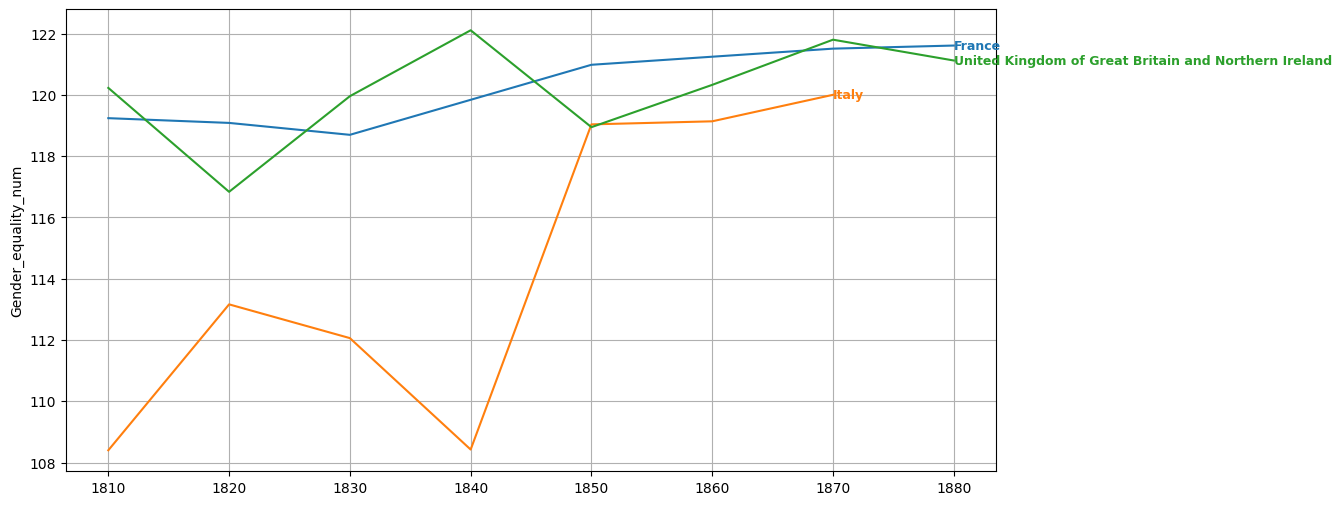

In [7]:
import matplotlib.pyplot as plt

df_fig = df_var[['year', 'country_name', var]].drop_duplicates()
df_fig = df_fig[df_fig['country_name'].isin(['France', 'Italy', 'China', 'United Kingdom of Great Britain and Northern Ireland'])]
df_fig = df_fig.sort_values(['year', 'country_name'])
df_fig = df_fig[df_fig['year']<=1880]


# Re-plotting with country labels near each line
plt.figure(figsize=(12, 6))

for region in df_fig['country_name'].unique():
    subset = df_fig[df_fig['country_name'] == region]
    line = plt.plot(subset['year'], subset[var], label=region)  # Store the line object
    
    # Get the color of the line
    line_color = line[0].get_color()  # Get the color of the first line (since the plot returns a list)
    
    # Adding text label near the end of each line with the same color as the line
    plt.text(subset['year'].values[-1], subset[var].values[-1], region, 
             verticalalignment='center', fontsize=9, weight='bold', color=line_color)

# Adding plot details
plt.title("")
plt.xlabel("")
plt.ylabel(var)
plt.grid(visible=True)

plt.show()


### Correlation with the PCI

In [8]:
### Load CPI
path = 'unseen_species_model/unseen_species_model_bayesian.csv'

df_cultura = pd.read_csv(path, index_col = [0])
df_cultura['N_est'] = df_cultura['f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
df_cultura = df_cultura.groupby(['region_name', 'decade']).agg({'N_est': 'sum', 'individual_wikidata_id':'count'}).reset_index()
df_cultura = df_cultura.rename(columns={"individual_wikidata_id": "score"})
df_cultura.head(10)


,region_name,decade,N_est,score
0,Arabic world,-610,5.529170,1
1,Arabic world,-400,2.611448,1
2,Arabic world,-360,14.825990,3
3,Arabic world,-330,6.061846,1
4,Arabic world,-310,6.022250,1
5,Arabic world,-300,24.011958,4
6,Arabic world,-280,5.966345,1
7,Arabic world,-270,23.797637,4
8,Arabic world,-260,11.867531,2
9,Arabic world,-250,5.919737,1


In [9]:
df_var_w = df_var_w.rename(columns={"region": "region_name"})

df = pd.merge(df_var_w, df_cultura, on = ['region_name', 'decade'])
df = df.rename(columns = {'decade': 'year'})
df.head(10)

,region_name,year,Gender_equality_num_weighted,N_est,score
0,Arabic world,1830,118.182570,189.699477,15
1,Arabic world,1840,116.194570,408.342396,28
2,Arabic world,1850,116.400160,660.192630,33
3,Arabic world,1860,113.859610,835.611448,51
4,Arabic world,1870,118.060080,658.681685,45
5,Arabic world,1880,112.446431,1277.379679,75
6,Central Europe,1810,106.299600,9967.084791,243
7,Central Europe,1820,103.803572,14913.711141,394
8,Central Europe,1830,108.585391,15789.296114,410
9,Central Europe,1840,101.516111,28031.946232,680


In [10]:


list(set(df.region_name))
df.region_name.value_counts()

keep = ['Indian world',
 'Nordic countries',
 'Persian world',
 'Portugal',
 'United Kingdom',
 'France',
 'Greek World',
 'Arabic world',
 'Chinese world',
 'Japan',
 'German world',
 'Low countries',
 'Italy',
 'Korea',
 'Spain']

# Apply normalization

df["century"] = df["year"].round(-2)
df["score_log"] = np.log(df["score"])
df["N_est_log"] = np.log(df["N_est"])
df["score_log_std"] = df["score_log"] / df["score_log"].mean()
df["N_est_std"] = df["N_est"] / df["N_est"].mean()
df["N_est_log_std"] = df["N_est_log"] / df["N_est_log"].mean()
df[f"log_{var}"] = np.log(df[f"{var}_weighted"])
df[f"log_{var}_std"] = df[f"log_{var}"] / df[f"log_{var}"].mean()
df[f"{var}_std"] = df[f"{var}_weighted"] / df[f"{var}_weighted"].mean()

df = df[df['region_name'].isin(keep)]
df

,region_name,year,Gender_equality_num_weighted,N_est,score,century,score_log,N_est_log,score_log_std,N_est_std,N_est_log_std,log_Gender_equality_num,log_Gender_equality_num_std,Gender_equality_num_std
0,Arabic world,1830,118.182570,189.699477,15,1800,2.708050,5.245441,0.474176,0.008539,0.601395,4.772231,1.003687,1.016315
1,Arabic world,1840,116.194570,408.342396,28,1800,3.332205,6.012106,0.583465,0.018381,0.689294,4.755266,1.000119,0.999219
2,Arabic world,1850,116.400160,660.192630,33,1800,3.496508,6.492532,0.612234,0.029718,0.744376,4.757034,1.000490,1.000987
3,Arabic world,1860,113.859610,835.611448,51,1900,3.931826,6.728164,0.688458,0.037614,0.771391,4.734966,0.995849,0.979139
4,Arabic world,1870,118.060080,658.681685,45,1900,3.806662,6.490240,0.666542,0.029650,0.744113,4.771194,1.003469,1.015261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,United Kingdom,1840,122.106130,12298.471136,936,1800,6.841615,9.417230,1.197958,0.553599,1.079695,4.804891,1.010556,1.050055
104,United Kingdom,1850,118.944430,12344.101231,909,1800,6.812345,9.420934,1.192833,0.555652,1.080120,4.778656,1.005038,1.022866
105,United Kingdom,1860,120.324804,15480.038693,1144,1900,7.042286,9.647307,1.233096,0.696812,1.106074,4.790195,1.007465,1.034737
106,United Kingdom,1870,121.799031,11764.644742,912,1900,6.815640,9.372854,1.193410,0.529569,1.074608,4.802372,1.010026,1.047415


In [11]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

df_ols = df[['region_name', 'year', f'log_{var}_std', 'N_est_log_std', 'score_log_std']].copy()

                  Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_Gender_equality_num_std
No. Observations: 78      Method:             REML                       
No. Groups:       13      Scale:              0.0000                     
Min. group size:  1       Log-Likelihood:     284.3179                   
Max. group size:  8       Converged:          Yes                        
Mean group size:  6.0                                                    
----------------------------------------------------------------------------
                   Coef.    Std.Err.       z       P>|z|    [0.025    0.975]
----------------------------------------------------------------------------
Intercept          0.992       0.006    155.737    0.000     0.979     1.004
N_est_log_std      0.010       0.007      1.469    0.142    -0.003     0.023
Group Var          0.000       0.004                                        



/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


(0.0, 1.0, 0.0, 1.0)

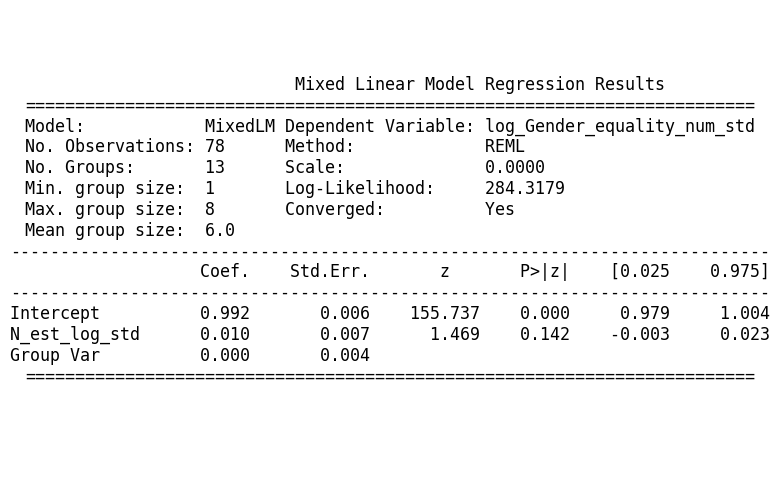

In [12]:


# Mixed Effects Model
model = smf.mixedlm(f"log_{var}_std ~ N_est_log_std", df_ols, groups=df_ols["region_name"])
result = model.fit()


sm_table = result.summary().tables[1]
sm_table.index = ['Intercept', 'alpha', 'Group Var']
sm_table['model'] = 'Corrected CPI'
sm_table = sm_table.reset_index()


# Output model summary to get R-square values if available (typically for OLS, not directly for MixedLM)
print(result.summary())


# Plotting the summary text
fig, ax = plt.subplots(figsize=(8, 6))
ax.text(0.5, 0.5, result.summary(), fontsize=12, va='center', ha='center', fontname='Monospace')
ax.axis('off')  # Turn off the axis

/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_86735/2205678226.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_86735/2205678226.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_86735/2205678226.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_86735/22056

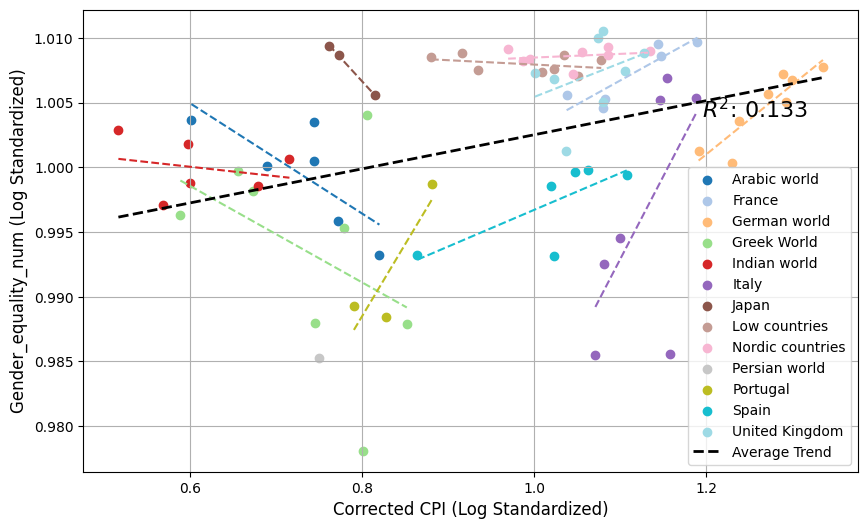

In [13]:
cmap = plt.get_cmap('tab20')
unique_regions = df_ols['region_name'].unique()
colors = cmap(np.linspace(0, 1, len(unique_regions)))
color_map = dict(zip(unique_regions, colors))

plt.figure(figsize=(10, 6))

# Plot individual data points and fit a regression line for each region
for name, group in df_ols.groupby('region_name'):
    # Fit OLS model for each region
    individual_ols_model = smf.ols(f"log_{var}_std ~ N_est_log_std", data=group).fit()
    
    # Plotting the scatter for each group
    plt.scatter(group['N_est_log_std'], group[f'log_{var}_std'], color=color_map[name], label=name)
    
    # Calculating the regression line
    x_vals = np.linspace(group['N_est_log_std'].min(), group['N_est_log_std'].max(), 100)
    y_vals = individual_ols_model.params['Intercept'] + individual_ols_model.params['N_est_log_std'] * x_vals
    plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)

# Fit a global OLS model to get the average trend line
average_ols_model = smf.ols(f"log_{var}_std ~ N_est_log_std", data=df_ols).fit()

# Calculate and plot the average trend line
x_vals_global = np.linspace(df_ols['N_est_log_std'].min(), df_ols['N_est_log_std'].max(), 100)
y_vals_global = average_ols_model.params['Intercept'] + average_ols_model.params['N_est_log_std'] * x_vals_global
plt.plot(x_vals_global, y_vals_global, 'k--', label='Average Trend', linewidth=2)

plt.legend()
plt.xlabel('Corrected CPI (Log Standardized)', fontsize=12)
plt.ylabel(f'{var} (Log Standardized)', fontsize=12)
plt.title('')
plt.grid(True)

# Display R-squared for the average trend line
r_squared = average_ols_model.rsquared
plt.figtext(0.85, 0.7, f'$R^2$: {r_squared:.3f}', ha='right', fontsize=16)

plt.show()

                  Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_Gender_equality_num_std
No. Observations: 70      Method:             REML                       
No. Groups:       12      Scale:              0.0000                     
Min. group size:  1       Log-Likelihood:     256.5095                   
Max. group size:  8       Converged:          Yes                        
Mean group size:  5.8                                                    
-----------------------------------------------------------------------------
                Coef.     Std.Err.       z        P>|z|     [0.025     0.975]
-----------------------------------------------------------------------------
Intercept       0.966        0.020     47.337     0.000      0.926      1.006
log_gdp_std     0.036        0.021      1.755     0.079     -0.004      0.076
Group Var       0.000        0.004                                           



/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


(0.0, 1.0, 0.0, 1.0)

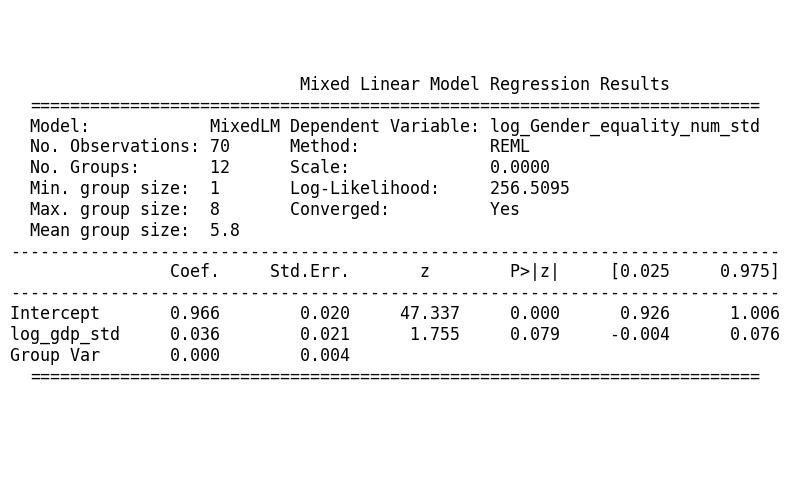

In [14]:
df_gdp = pd.read_csv("other_data/gdp_weighted_pop_decade.csv")
df_gdp = df_gdp.rename(columns={"region": "region_name", "decade":"year",'gdp_pc_weighted':'gdp_per_capita'})

new_df = pd.merge(df, df_gdp, on = ["region_name","year"])
new_df["log_gdp"] = np.log(new_df["gdp_per_capita"])
new_df["log_gdp_std"] = new_df["log_gdp"] / new_df["log_gdp"].mean()


df_ols = new_df[['region_name', 'year', f'log_{var}_std', 'log_gdp_std']].copy()

# Mixed Effects Model
model = smf.mixedlm(f"log_{var}_std ~ log_gdp_std", df_ols, groups=df_ols["region_name"])
result_gdp = model.fit()

sm_table_gdp = result_gdp.summary().tables[1]
sm_table_gdp.index = ['Intercept', 'alpha', 'Group Var']
sm_table_gdp['model'] = 'Corrected CPI'
sm_table_gdp = sm_table_gdp.reset_index()

# Output model summary to get R-square values if available (typically for OLS, not directly for MixedLM)
print(result_gdp.summary())


# Plotting the summary text
fig, ax = plt.subplots(figsize=(8, 6))
ax.text(0.5, 0.5, result_gdp.summary(), fontsize=12, va='center', ha='center', fontname='Monospace')
ax.axis('off')  # Turn off the axis

In [15]:
# Fit a global OLS model to get the average trend line
average_ols_model_gdp = smf.ols(f"log_{var}_std ~ log_gdp_std", data=df_ols).fit()

# Display R-squared for the average trend line
r_squared_gdp = average_ols_model_gdp.rsquared

dict_indicator = []

n_obs = int(result.summary().tables[0].iloc[1][1])
n_obs_gdp =  int(result_gdp.summary().tables[0].iloc[1][1])

dict_indicator.append({'indicator':var, 
                       'coeff_indicator':sm_table.iloc[1]['Coef.'], 
                       'p_value_indicator':sm_table.iloc[1]['P>|z|'], 
                        'r2_indicator':r_squared,
                       'N_indicator':n_obs,
                       'coeff_gdp':sm_table_gdp.iloc[1]['Coef.'],
                       'p_value_gdp':sm_table_gdp.iloc[1]['P>|z|'], 
                        'p_value_gdp':sm_table_gdp.iloc[1]['P>|z|'],
                        'r2_gdp':r_squared_gdp, 
                        'N_gdp':n_obs_gdp}
                       )
final_table = pd.DataFrame(dict_indicator)
final_table.to_csv(f'df_indicators_hdi/{var}.csv')
final_table

,indicator,coeff_indicator,p_value_indicator,r2_indicator,N_indicator,coeff_gdp,p_value_gdp,r2_gdp,N_gdp
0,Gender_equality_num,0.010,0.142,0.133104,78,0.036,0.079,0.099722,70


<!-- ### Load Culture -->